In [1]:
import nltk
import pandas as pd
%pylab inline
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models, similarities
import re
import random
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Resort NAAG codes into CUSP_NAAG codes

In [2]:
#Add in NAAG codes where aviable
# 0 = no naag code
naag = pd.read_csv('NAAG Codes.csv')
naag['CUSP_NAAG'] = naag.NAAG_DESCRIPTION
naag.CUSP_NAAG.replace(['Landlord/Tenant: Rent Security Deposits or Security Interest',
                       'Home Repair/Construction: New Home Warranties',
                       'Campgrounds/Time Shares',
                       'Landlord/Tenant: Other',
                       'Landlord/Tenant: Harassment',
                       'Landlord/Tenant: Mobile (manufactured) Home Sales',
                       'Home Repair/Construction: Home Improvement/Repair/Contractors',
                       'Home Repair/Construction: New Home Warranties',
                       'Home Repair/Construction: New Home Sales',
                       'Services: Real Estate Brokers/Apartment',
                       'Landlord/Tenant: Rent Security Deposits or Security Interest'
                       'Insurance: Homeowner/Rental Insurance',
                       'Landlord/Tenant: Mobile (manufactured) Home Sales, Warranties and Parks',
                       'Insurance: Homeowner/Rental Insurance'],
                       'Residential', inplace = True)

naag.CUSP_NAAG.replace(['Mail Order: Other',
                       'Direct Mail/Unsolicited Faxes',
                       'Mail Order: Computers & Software',
                       'Internet',
                       'Contests/Sweepstakes',
                       'Services: Movers',
                       'Telemarketing: Other',
                       'Door-to-Door Sales',
                       'Subscriptions(magazines, records, videos, etc.',
                       'Entertainment: Other Entertainment/Recreation',
                        'Services: Employment Training',
                        'Charities',
                        'Services: Special Occasions',
                        'Utilities: Telecom: Slamming',
                        'Utilities: Telecom: Pay-Per-Call',
                        'Telemarketing: Unwanted Calls',
                        'Utilities: Telecom: Phone Cards'
                       'Utilities: Telecom: Cramming',
                       'Subscriptions(magazines, records, videos, etc.)'],
                       'scams', inplace = True)

naag.CUSP_NAAG.replace(['Price Gouging',
                       'Credit: Debt Collector',
                       'Credit Management: Debt Settlement',
                       'Credit Management: Budget Planning/Debt Consolidation',
                       'Telemarketing', 
                        'Banking - Not Mortgage/Credit Card Related',
                       'Real Estate Finance',
                       'Credit: Credit Cards',
                        'Credit: Identity Theft',
                        'Credit Management: Credit Reporting',
                        'Credit: Pay Day Loan',
                        'Credit: Other (except credit reporting)',
                        'Credit Management: Credit Repair',
                        'Credit: Security Breach Notices',
                        'Mortgages: Mortgage and Loan Brokers',
                        'Mortgages: Mortgage Modification',
                        'Mortgages: Other',
                        'Mortgages: Mortgage Foreclosure',
                        'Investor Protection',
                        'Insurance: Other',
                        'Student Loans'],
                       'financial', inplace = True)

naag.CUSP_NAAG.replace(['Retail:   Retail Sales (excluding consumer electronics and furniture/appliances)',
                       'Retail: Electronics: Other',
                        'Retail: Pet Stores/Animal Breeders',
                        'Retail: Electronics: Computers & Software',
                        'Retail: Rent-to-Own (all products)',
                        'Insurance: Life Insurance',
                        'Manufacturer',
                        'Health',
                        'Health Clubs',
                        'Services: Alarm Company',
                        'Furniture/Major Household Appliances',
                        'Entertainment: Entertainment/Tickets',
                        'Services: Dating Services'],
                       'good_n_services', inplace = True)

naag.CUSP_NAAG.replace(['Labor',
                       'Criminal',
                        'Civil Rights',
                        'Civil Recoveries',
                        'Services: Immigration Service Providers',
                        'Government Agencies',
                        'Services: Schools',
                        'Environmental',
                        'Public Integrity',
                       'Anti-trust'],
                       'government', inplace = True)

naag.CUSP_NAAG.replace(['Utilities: Cable',
                       'Utilities: ESCOs - Unregulated Energy Service Suppliers',
                       'Utilities: Digital Satellite Systems (DSS)',
                       'Utilities: Water, Oil, Gas, Electric',
                        'Utilities: Bundling',
                        'Utilities: Telecom: Cellular Telephone Service',
                        'Utilities: Telecom: Residential Telephones',
                        'Utilities: Telecom: Phone Cards'
                        'Utilities: Telecom: Cramming',
                       'Utilities: Telecom: Phone Cards',
                       'Utilities: Telecom: Cramming'],
                       'utilities', inplace = True)

naag.CUSP_NAAG.replace(['Misc: Other', 
                        'NAAG to be determined',
                        'Misc: Business Opportunities',
                        'Misc: Business Opportunities',
                        'Misc: Business-to-Business',
                        'Services: Other',
                        'Misc: Business-to-Business',
                        'Services: Professional Services (non medical)',
                       'Services: Other'],
                       'misc', inplace = True)
 
naag.CUSP_NAAG.replace(['Travel',
                       'Automobiles: Used',
                       'Gasoline Prices',
                        'Automobiles: Repairs',
                        'Automobiles: Other Industry-related',
                        'Automobiles: Leases',
                        'Insurance: Auto or Boat Insurance',
                        'Automobiles: Service Contracts',
                        'Automobiles: Rentals',
                        'Recreation Vehicles: Boat/Marine',
                        'Recreation Vehicles: Snowmobiles',
                       'Automobiles: New'],
                       'travel',inplace = True)   
    
naag.CUSP_NAAG.replace(['Nan', np.nan], 'None', inplace = True)
    
cusp_nagg_code_descriptions = naag.CUSP_NAAG.unique()
cusp_nagg_codes = range(len(naag.CUSP_NAAG.unique()))

cusp_codes = pd.DataFrame(cusp_nagg_code_descriptions, columns = ['CUSP_NAAG'])
cusp_codes['cusp_code'] = cusp_nagg_codes
naag = naag.merge(cusp_codes, on = 'CUSP_NAAG', how = 'inner')

## Load OAG Internal Online Complaints

In [14]:
x = naag.groupby('CUSP_NAAG').count().reset_index()

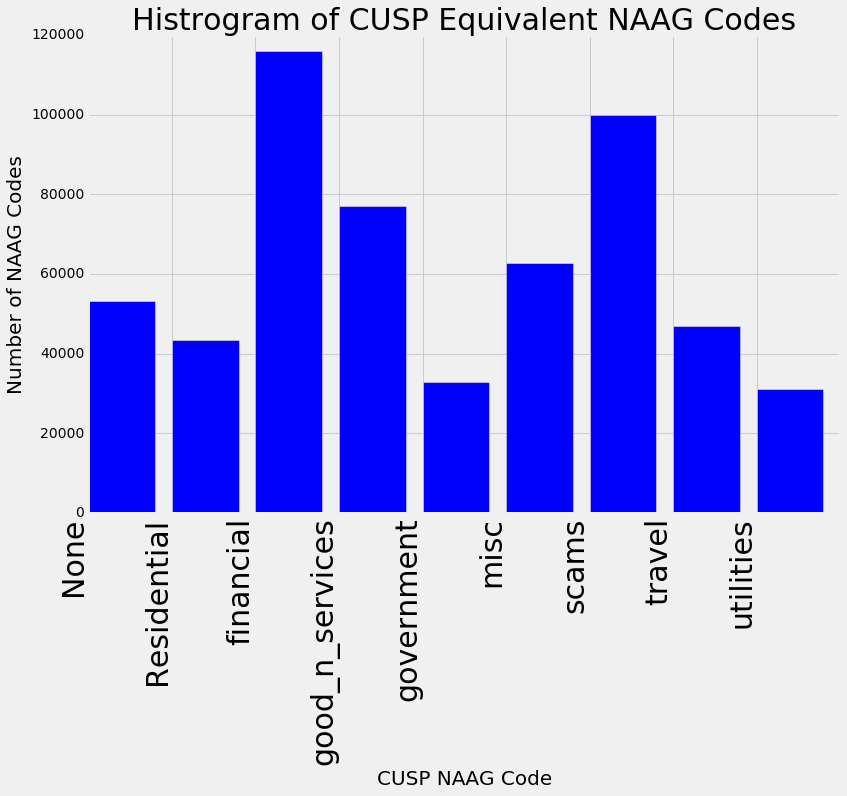

In [66]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize = (12, 8))
x = x[['CUSP_NAAG', 'MATTER_ID']]
plt.bar(range(len(x)), x.MATTER_ID)
ax.set_xticklabels(x.CUSP_NAAG, rotation = 90, ha = 'right', va = 'top', size = 30)

ax.set_title('Histrogram of CUSP Equivalent NAAG Codes', size =30)
ax.set_xlabel('CUSP NAAG Code', size = 20)
ax.set_ylabel('Number of NAAG Codes', size = 20)


In [3]:
#Load Consumer Financial Protection Bureau public data set.  Found at:
#http://www.consumerfinance.gov/data-research/consumer-complaints/
#cfpb = pd.read_csv("Consumer_Complaints_with_Consumer_Complaint_Narratives.csv")

In [4]:
#Load OAG Sivlercase Database
silvercase = pd.read_csv("OAG Complaints-Online_Final.csv")

## Merge in NAAG Codes

In [5]:
silvercase.MATTER_ID = silvercase.MATTER_ID.str.replace(',', '')
silvercase.MATTER_ID = silvercase.MATTER_ID.astype(int)
silvercase = silvercase.merge(naag, how= 'inner', on = 'MATTER_ID')

In [8]:
silvercase.to_pickle('OAG_corpus_with_CUSP_code.pkl')

In [9]:
#Only keep unique descriptions
start = len(silvercase)
print 'There are %s entries for narritives in the database' % start
silvercase = silvercase.drop_duplicates(subset = 'COMPLAINT_DESCRIPTION')
afterduplicates = len(silvercase)
print 'There are %s duplicate entries leaving %s unique descriptions' % (start-afterduplicates, afterduplicates )

#reset index
silvercase.reset_index(drop = True, inplace = True)

#establish corpus as strings
silvercase['silvercase_corpus'] = list(silvercase.COMPLAINT_DESCRIPTION.apply(str))

#Count the number of words in each description and only keep entries greater than or equal to 10 words
numwords = []
for doc in range(len(silvercase)):
    numwords.append(len(silvercase.silvercase_corpus[doc]))
silvercase['numwords'] = numwords
silvercase['fraud'] = 1
silvercase = silvercase[silvercase.numwords >=100]
afterlength = len(silvercase)
silvercase.reset_index(inplace = True, drop = True)
print 'There were %s entries with less than 100 words, leaving a final database of %s entires' % (afterduplicates - afterlength , afterlength)



There are 15000 entries for narritives in the database
There are 3389 duplicate entries leaving 11611 unique descriptions
There were 596 entries with less than 100 words, leaving a final database of 11015 entires


## Combine into one corpus

In [12]:
print 'There are %s narritives of fraud in the OAG databse' % len(silvercase.silvercase_corpus)
print 'There are %s tweets' % len(tweets.Tweet.drop_duplicates())
corpus = pd.DataFrame(silvercase.silvercase_corpus.append(tweets.Tweet.drop_duplicates()), columns= ['documents'])
print 'There are %s documents in the corpus' % len(corpus)
corpus['fraud'] = 0
corpus.fraud[0:len((silvercase.silvercase_corpus))] = 1
corpus.reset_index(inplace = True)
corpus.columns = ['original_Index', 'documents', 'fraud']
corpus.documents = corpus.documents.astype(str)

There are 11015 narritives of fraud in the OAG databse
There are 3361685 tweets
There are 3372700 documents in the corpus


/Users/maxfacts/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
corpus['cusp_code'] = 0
corpus['cusp_code'][-len(tweets.Tweet.drop_duplicates()):] = 9999
corpus['cusp_code'][0:len(silvercase.silvercase_corpus)] = silvercase.cusp_code

/Users/maxfacts/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/maxfacts/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
